<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN from scratch

In this section, we'll train a CNN from scratch using a dataset stored in a zip file. We'll conduct experiments with increasingly complex neural networks to analyze the results.

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime
from keras.utils import plot_model

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/
replace /content/dataset/content/splitted_dataset/validation_set/clothes/shoes1263.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam', train_dataset=train_dataset):

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,),
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# CNN Implementation

## Model 1: Standard CNN

In this section, we'll train the model using a standard CNN, gradually adding complexity to the network and comparing the results. To reduce overfitting, we'll also apply techniques such as normalization, data augmentation, and dropouts.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                       

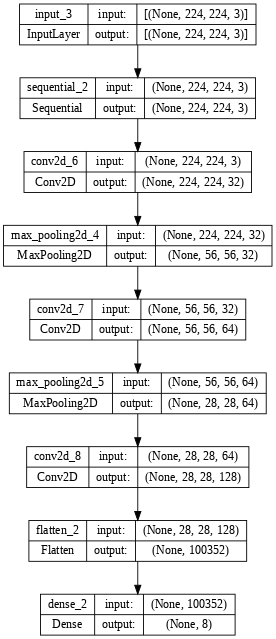

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "standardCNN"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'standardCNN.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

### Sanity check

We want to ensure that our model is capable of learning from the data without memorizing it too closely. By training the model on a limited amount of data, we could observe its performance and evaluate whether it was able to generalize well to new examples.

In [ ]:
training_set_reduced = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split=0.80,
    subset='training'
)

Found 7040 files belonging to 8 classes.
Using 1408 files for training.


Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.1636 - accuracy: 0.6051
Epoch 1: val_loss improved from inf to 1.40904, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
11/11 [==============================] - 9s 550ms/step - loss: 1.1636 - accuracy: 0.6051 - val_loss: 1.4090 - val_accuracy: 0.5389
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.0798 - accuracy: 0.6286
Epoch 2: val_loss improved from 1.40904 to 1.32503, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
11/11 [==============================] - 8s 713ms/step - loss: 1.0798 - accuracy: 0.6286 - val_loss: 1.3250 - val_accuracy: 0.5574
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.6562
Epoch 3: val_loss did not improve from 1.32503
11/11 [==============================] - 6s 465ms/step - loss: 1.0111 - accuracy: 0.6562 - val_loss: 1.3891 - val_accuracy: 0.5277
Epoch 4/100

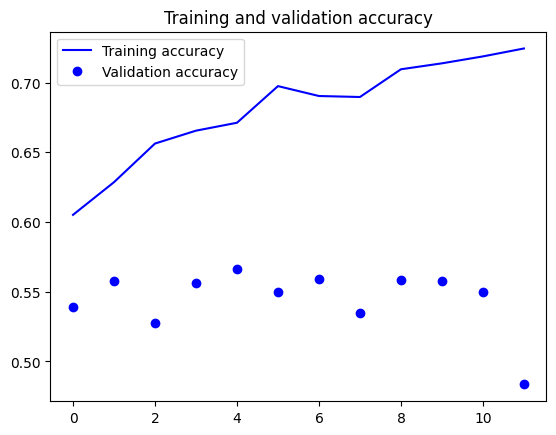

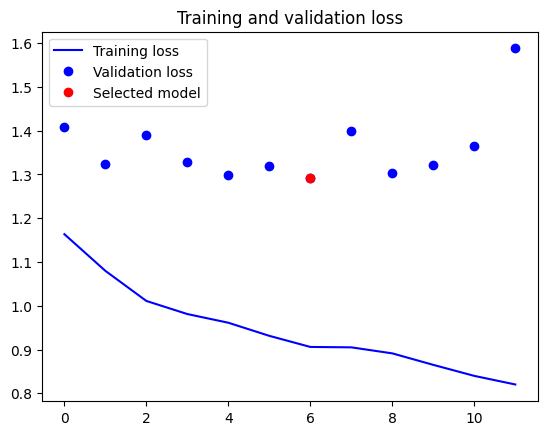

Lowest validation loss has been reached at epoch 6 with validation accuracy of 0.559


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001, train_dataset=training_set_reduced)

### Compile and fit on entire dataset

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8142 - accuracy: 0.3234
Epoch 1: val_loss improved from inf to 1.67641, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
55/55 [==============================] - 21s 295ms/step - loss: 1.8142 - accuracy: 0.3234 - val_loss: 1.6764 - val_accuracy: 0.3726
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4383 - accuracy: 0.4848
Epoch 2: val_loss improved from 1.67641 to 1.38476, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
55/55 [==============================] - 16s 266ms/step - loss: 1.4383 - accuracy: 0.4848 - val_loss: 1.3848 - val_accuracy: 0.5320
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.2946 - accuracy: 0.5413
Epoch 3: val_loss improved from 1.38476 to 1.38450, saving model to /content/drive/My Drive/project/models/standardCNN/standardCNN.h5
55/55 [==============================] - 16s 269ms/st

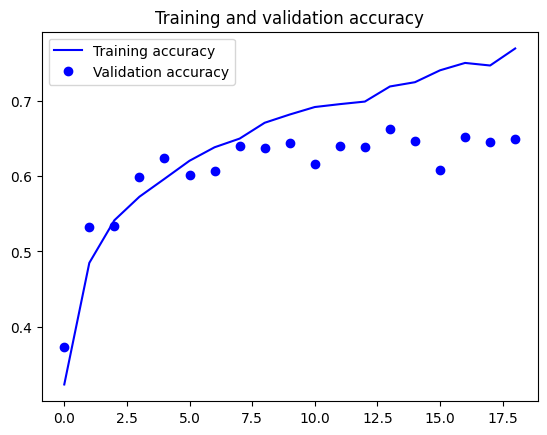

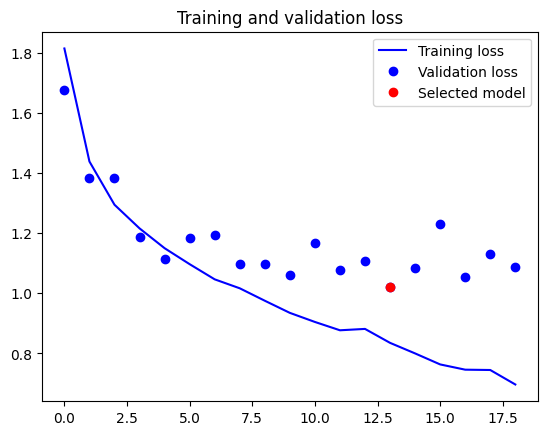

Lowest validation loss has been reached at epoch 13 with validation accuracy of 0.663


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 5s 245ms/step - loss: 0.9767 - accuracy: 0.6735
Test accuracy: 0.674, test loss: 0.977
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1608    0.8027    0.2679       147
           1     0.9382    0.6826    0.7902      1112
           2     0.7872    0.3841    0.5163       289
           3     0.4167    0.1531    0.2239        98
           4     0.6364    0.6788    0.6569       165
           5     0.6880    0.5590    0.6169       288
           6     0.6441    0.2901    0.4000       131
           7     0.4532    0.6429    0.5316        98

    accuracy                         0.5915      2328
   macro avg     0.5906    0.5241    0.5005      2328
weighted avg     0.7591    0.5915    0.6356      2328



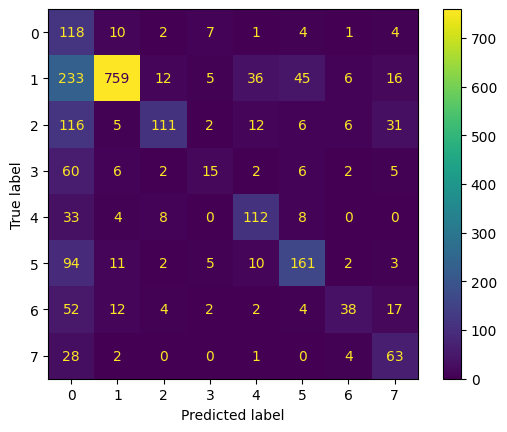

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

The model quickly begins to overfit, and after epoch 5, there are only a slight improvement in validation loss. This is likely due to the model's simplicity, and we need to add more layers to increase its depth and improve its performance.

## Model 2: One dense layer and four Conv2D layers

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

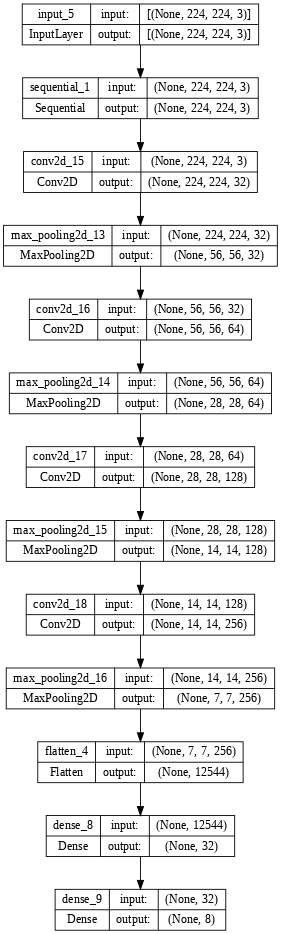

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "OneDense4Conv2D"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'OneDense4Conv2D.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.2200
Epoch 1: val_loss improved from inf to 1.91842, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [==============================] - 20s 300ms/step - loss: 1.9667 - accuracy: 0.2200 - val_loss: 1.9184 - val_accuracy: 0.1577
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.6970 - accuracy: 0.3497
Epoch 2: val_loss improved from 1.91842 to 1.79548, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [==============================] - 16s 281ms/step - loss: 1.6970 - accuracy: 0.3497 - val_loss: 1.7955 - val_accuracy: 0.2750
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.5778 - accuracy: 0.4161
Epoch 3: val_loss improved from 1.79548 to 1.63314, saving model to /content/drive/My Drive/project/models/OneDense4Conv2D/OneDense4Conv2D.h5
55/55 [======================

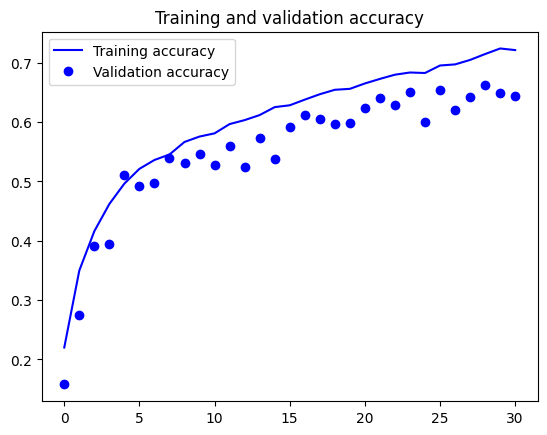

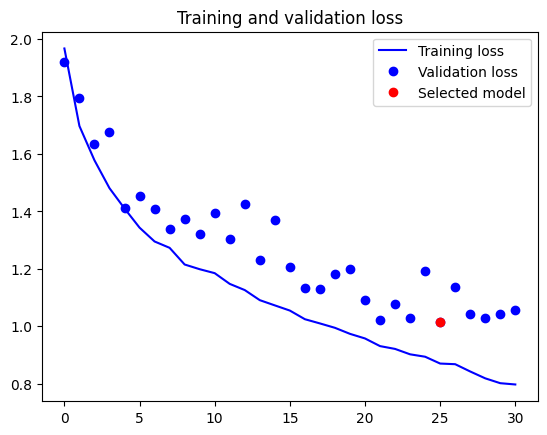

Lowest validation loss has been reached at epoch 25 with validation accuracy of 0.653


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 180ms/step - loss: 0.9603 - accuracy: 0.6701
Test accuracy: 0.670, test loss: 0.960
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.1560    0.8163    0.2620       147
           1     0.9620    0.6376    0.7669      1112
           2     0.7802    0.4913    0.6030       289
           3     0.3861    0.3980    0.3920        98
           4     0.6875    0.6667    0.6769       165
           5     0.6053    0.5590    0.5812       288
           6     0.5532    0.1985    0.2921       131
           7     0.7576    0.5102    0.6098        98

    accuracy                         0.5829      2328
   macro avg     0.6110    0.5347    0.5230      2328
weighted avg     0.7691    0.5829    0.6362      2328



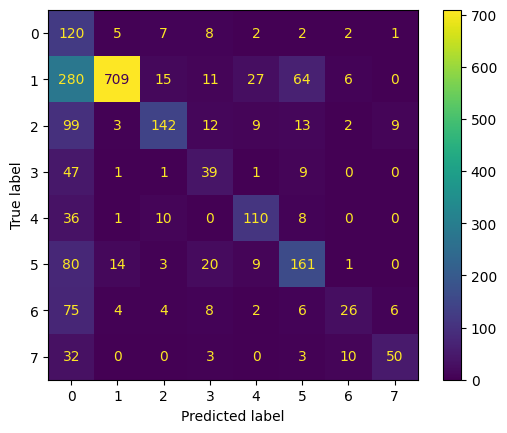

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations


The dense layer allows us to reduce overfitting and it slightly increases the prediction power. Now we need to minimize the overfitting by adding dropout layers.

##Model 3: One Dropout and Dense layer

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

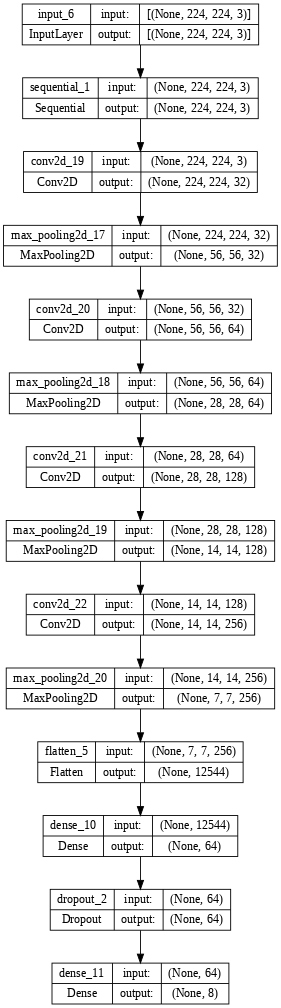

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "OneDropout64Dense"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'OneDropout64Dense.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9740 - accuracy: 0.2138
Epoch 1: val_loss improved from inf to 1.77814, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==============================] - 20s 304ms/step - loss: 1.9740 - accuracy: 0.2138 - val_loss: 1.7781 - val_accuracy: 0.3262
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7710 - accuracy: 0.3132
Epoch 2: val_loss improved from 1.77814 to 1.65514, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==============================] - 17s 283ms/step - loss: 1.7710 - accuracy: 0.3132 - val_loss: 1.6551 - val_accuracy: 0.4001
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.6656 - accuracy: 0.3679
Epoch 3: val_loss improved from 1.65514 to 1.62952, saving model to /content/drive/My Drive/project/models/OneDropout64Dense/OneDropout64Dense.h5
55/55 [==========

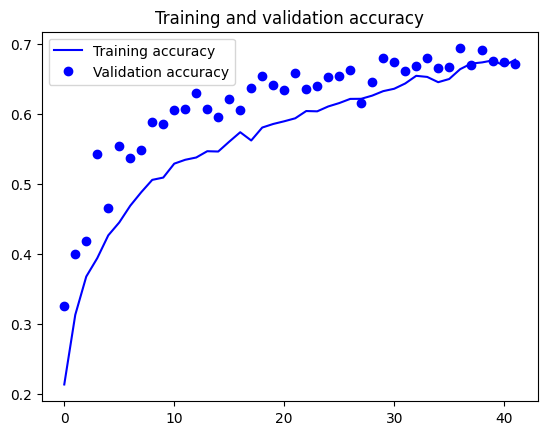

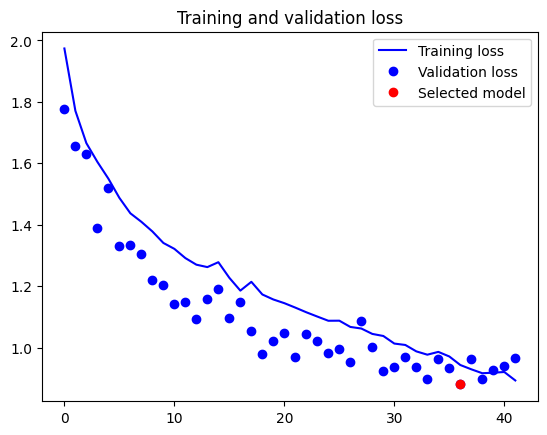

Lowest validation loss has been reached at epoch 36 with validation accuracy of 0.694


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 182ms/step - loss: 0.8431 - accuracy: 0.7045
Test accuracy: 0.704, test loss: 0.843
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1640    0.8367    0.2742       147
           1     0.9580    0.6969    0.8069      1112
           2     0.8023    0.4775    0.5987       289
           3     0.5227    0.2347    0.3239        98
           4     0.6507    0.8242    0.7273       165
           5     0.7143    0.5035    0.5906       288
           6     0.6724    0.2977    0.4127       131
           7     0.6867    0.5816    0.6298        98

    accuracy                         0.6168      2328
   macro avg     0.6464    0.5566    0.5455      2328
weighted avg     0.7908    0.6168    0.6650      2328



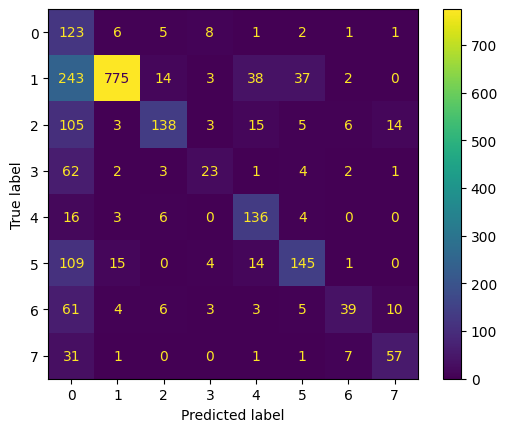

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

The dropout layer, along with the size of the network, leads to an underfitting condition. Therefore, the solution is to increase the size of the network by adding a dense layer.
The performances compared to the previous models are better both on the validation and on the test set.

##Model 4: Two Dropout and Dense layer

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

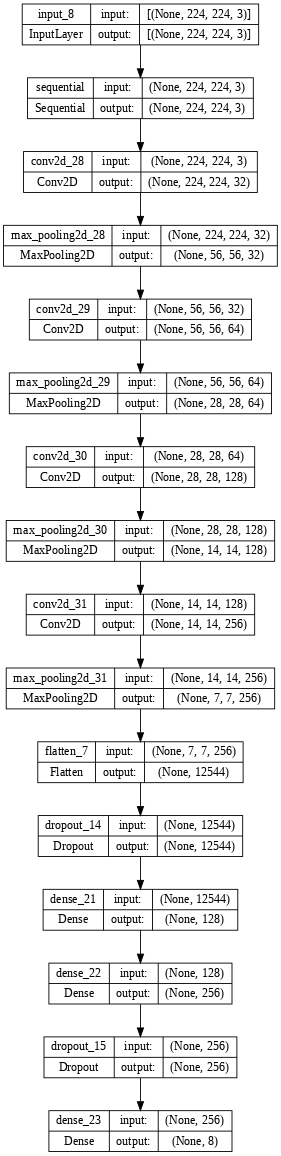

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "TwoDropout128Dense"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'TwoDropout128Dense.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9780 - accuracy: 0.2119
Epoch 1: val_loss improved from inf to 1.80301, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [==============================] - 20s 292ms/step - loss: 1.9780 - accuracy: 0.2119 - val_loss: 1.8030 - val_accuracy: 0.2720
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7030 - accuracy: 0.3470
Epoch 2: val_loss improved from 1.80301 to 1.59547, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [==============================] - 16s 278ms/step - loss: 1.7030 - accuracy: 0.3470 - val_loss: 1.5955 - val_accuracy: 0.4087
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.5510 - accuracy: 0.4295
Epoch 3: val_loss improved from 1.59547 to 1.49521, saving model to /content/drive/My Drive/project/models/TwoDropout128Dense/TwoDropout128Dense.h5
55/55 [====

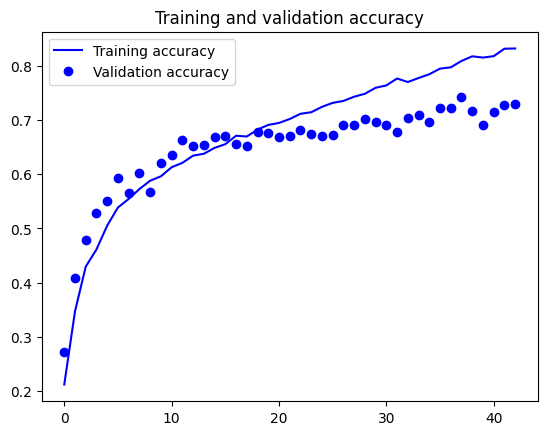

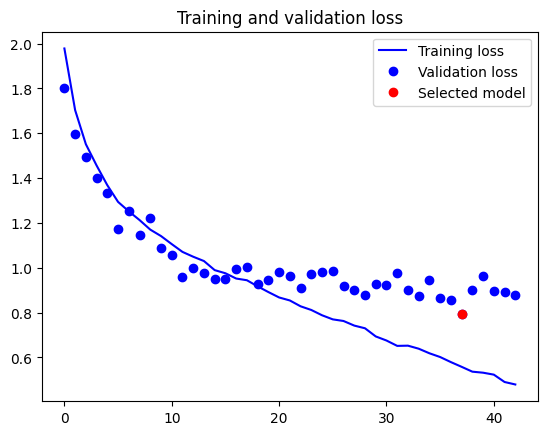

Lowest validation loss has been reached at epoch 37 with validation accuracy of 0.743


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 3s 169ms/step - loss: 0.7331 - accuracy: 0.7543
Test accuracy: 0.754, test loss: 0.733
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 7 0 0]
              precision    recall  f1-score   support

           0     0.2472    0.7551    0.3725       147
           1     0.9556    0.7941    0.8674      1112
           2     0.7571    0.5502    0.6373       289
           3     0.5185    0.4286    0.4693        98
           4     0.6780    0.8424    0.7514       165
           5     0.7663    0.6944    0.7286       288
           6     0.6237    0.4427    0.5179       131
           7     0.6381    0.6837    0.6601        98

    accuracy                         0.7126      2328
   macro avg     0.6481    0.6489    0.6255      2328
weighted avg     0.7927    0.7126    0.7370      2328



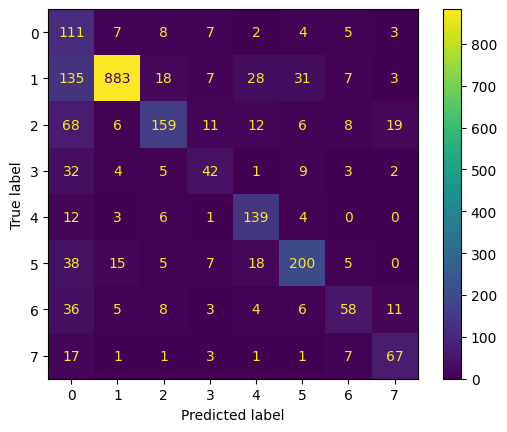

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

By using two Dense layers with 128 and 256 units respectively, the model is able to improve the results of the previous CNNs on both the validation and test sets. The Dense layers allow the model to learn the more complex relationships between the input data features, while the two dropout layers help to minimize overfitting.

## Model 5: Normalization layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                           

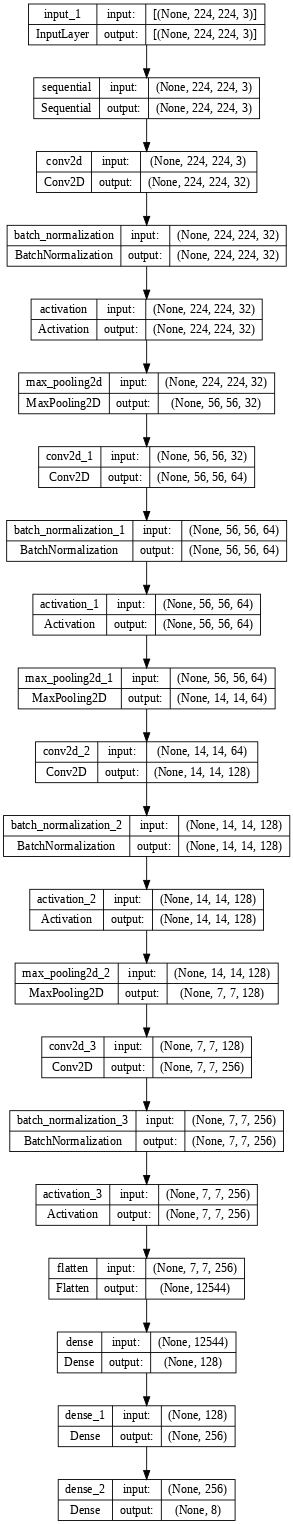

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = layers.Conv2D(filters=32, padding='same', kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(('relu'))(x)
x = layers.MaxPooling2D(pool_size=4)(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(('relu'))(x)
x = layers.MaxPooling2D(pool_size=4)(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(('relu'))(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, padding='same', kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(('relu'))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "BatchNormalizationLayer"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'BatchNormalizationLayer.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.5462
Epoch 1: val_loss improved from inf to 2.21517, saving model to /content/drive/My Drive/project/models/BatchNormalizationLayer/BatchNormalizationLayer.h5
55/55 [==============================] - 25s 351ms/step - loss: 1.2994 - accuracy: 0.5462 - val_loss: 2.2152 - val_accuracy: 0.0563
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.6901
Epoch 2: val_loss did not improve from 2.21517
55/55 [==============================] - 17s 292ms/step - loss: 0.9057 - accuracy: 0.6901 - val_loss: 2.5333 - val_accuracy: 0.0576
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.7594
Epoch 3: val_loss did not improve from 2.21517
55/55 [==============================] - 16s 279ms/step - loss: 0.7083 - accuracy: 0.7594 - val_loss: 2.7006 - val_accuracy: 0.1143
Epoch 4/100
55/55 [==============================] - ETA: 0s - loss: 0.

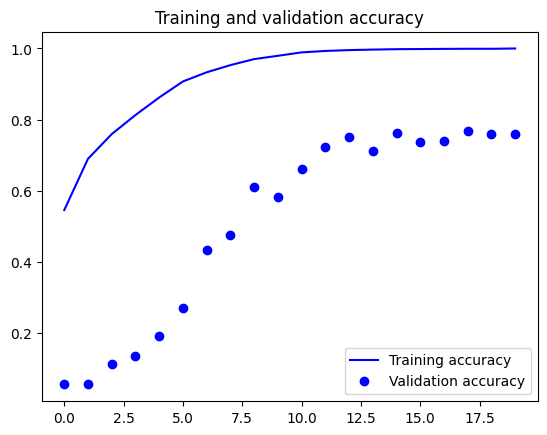

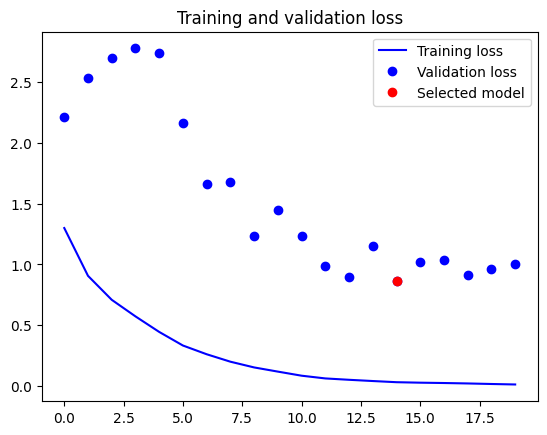

Lowest validation loss has been reached at epoch 14 with validation accuracy of 0.761


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 5s 255ms/step - loss: 0.7855 - accuracy: 0.7809
Test accuracy: 0.781, test loss: 0.785
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 7 0 3]
              precision    recall  f1-score   support

           0     0.3601    0.7619    0.4891       147
           1     0.9533    0.8076    0.8744      1112
           2     0.8259    0.5744    0.6776       289
           3     0.4444    0.7347    0.5538        98
           4     0.7551    0.8970    0.8199       165
           5     0.8007    0.7535    0.7764       288
           6     0.6061    0.6107    0.6084       131
           7     0.6549    0.7551    0.7014        98

    accuracy                         0.7590      2328
   macro avg     0.6751    0.7368    0.6876      2328
weighted avg     0.8136    0.7590    0.7739      2328



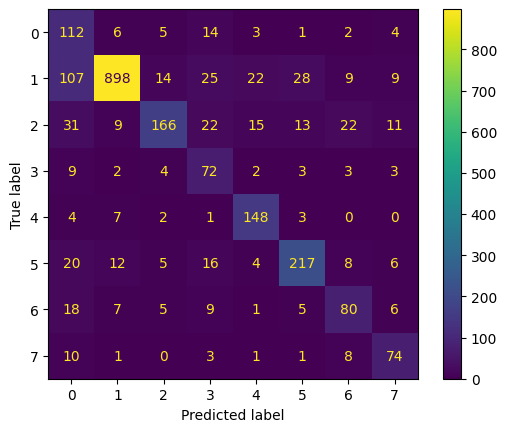

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Consideration

Using Batch Normalization layers can slightly improve test and validation accuracy, but it may lead to significant overfitting from the start. The performance improvement is not justified by the high level of overfitting, indicating that the task is not suitable for our case.

##Model 6: Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.2), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                           

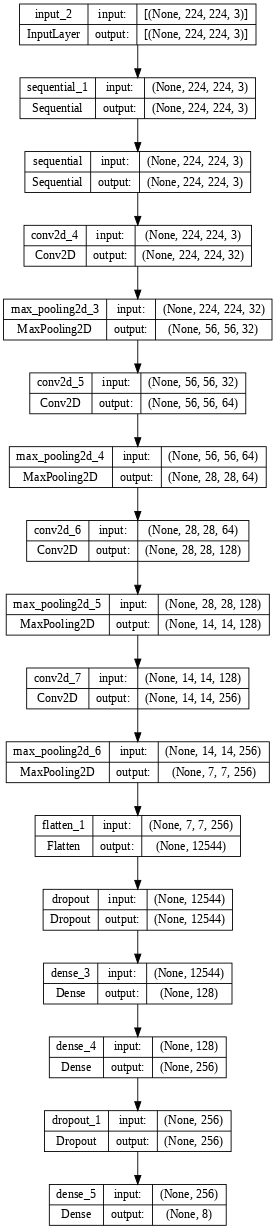

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = layers.Conv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "DataAugmentationLayer"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'DataAugmentationLayer.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0386 - accuracy: 0.1844
Epoch 1: val_loss improved from inf to 1.98813, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLayer.h5
55/55 [==============================] - 20s 291ms/step - loss: 2.0386 - accuracy: 0.1844 - val_loss: 1.9881 - val_accuracy: 0.1143
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.7722 - accuracy: 0.3135
Epoch 2: val_loss improved from 1.98813 to 1.63939, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLayer.h5
55/55 [==============================] - 17s 285ms/step - loss: 1.7722 - accuracy: 0.3135 - val_loss: 1.6394 - val_accuracy: 0.4108
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.6122 - accuracy: 0.3912
Epoch 3: val_loss improved from 1.63939 to 1.53427, saving model to /content/drive/My Drive/project/models/DataAugmentationLayer/DataAugmentationLa

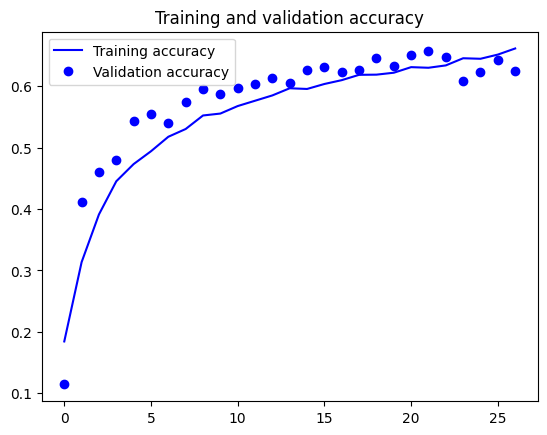

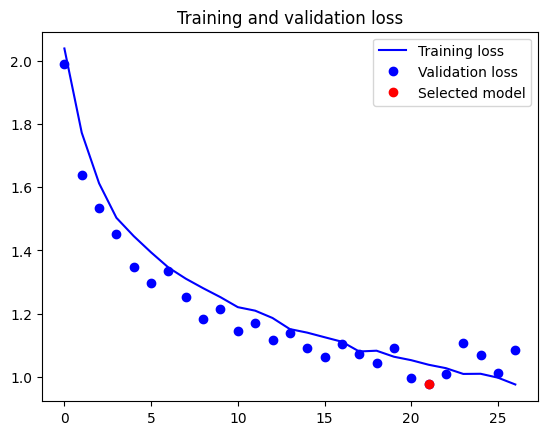

Lowest validation loss has been reached at epoch 21 with validation accuracy of 0.657


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

### Evaluation

19/19 [==============================] - 4s 200ms/step - loss: 0.9457 - accuracy: 0.6723
Test accuracy: 0.672, test loss: 0.946
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1664    0.8639    0.2791       147
           1     0.9558    0.6799    0.7945      1112
           2     0.9027    0.3529    0.5075       289
           3     0.3333    0.2245    0.2683        98
           4     0.6720    0.7576    0.7123       165
           5     0.6113    0.5625    0.5859       288
           6     0.7561    0.2366    0.3605       131
           7     0.5825    0.6122    0.5970        98

    accuracy                         0.5949      2328
   macro avg     0.6225    0.5363    0.5131      2328
weighted avg     0.7835    0.5949    0.6398      2328



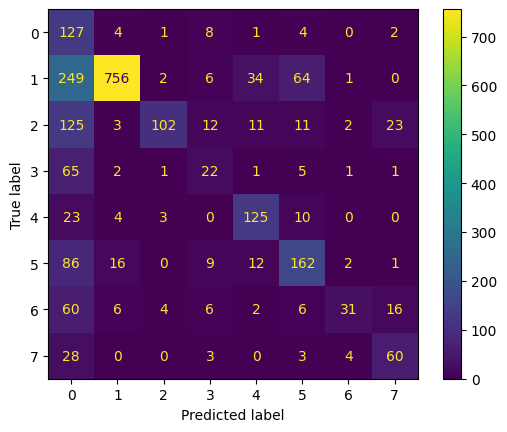

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

### Considerations

The utilization of data augmentation techniques in this case does not prove to be beneficial. Both the accuracy and loss on both the validation and test sets show worse results.

# Evaluating results

In [ ]:
test_1 = tf.keras.models.load_model(os.path.join(models_path, "standardCNN/standardCNN.h5"))
test_2 = tf.keras.models.load_model(os.path.join(models_path, "OneDense4Conv2D/OneDense4Conv2D.h5"))
test_3 = tf.keras.models.load_model(os.path.join(models_path, "OneDropout64Dense/OneDropout64Dense.h5"))
test_4 = tf.keras.models.load_model(os.path.join(models_path, "TwoDropout128Dense/TwoDropout128Dense.h5"))
test_5 = tf.keras.models.load_model(os.path.join(models_path, "BatchNormalizationLayer/BatchNormalizationLayer.h5"))
test_6 = tf.keras.models.load_model(os.path.join(models_path, "DataAugmentationLayer/DataAugmentationLayer.h5"))
test_7 = tf.keras.models.load_model(os.path.join(models_path, "residual_module/residual_module.h5"))
test_8 = tf.keras.models.load_model(os.path.join(models_path, "residual_module_deeper/residual_module_deeper.h5"))
test_9 = tf.keras.models.load_model(os.path.join(models_path, "depthwise_separable_conv/depthwise_separable_conv.h5"))
test_10 = tf.keras.models.load_model(os.path.join(models_path, "depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5"))
test_11 = tf.keras.models.load_model(os.path.join(models_path, "naive_inception_module/naive_inception_module.h5"))
test_12 = tf.keras.models.load_model(os.path.join(models_path, "complete_inception_module/complete_inception_module.h5"))

In [ ]:
models_name = ["standardCNN", "dense + conv" , "64dense + drop", "128 dense + 2drop", "batch norm", "data aug", "res module", "res module deeper",
                "depthwise sep conv", "depthwise sep conv deep", "naive inc layer", "compl inc layer"]
test_1_loss, test_1_acc = test_1.evaluate(test_dataset)
test_2_loss, test_2_acc = test_2.evaluate(test_dataset)
test_3_loss, test_3_acc = test_3.evaluate(test_dataset)
test_4_loss, test_4_acc = test_4.evaluate(test_dataset)
test_5_loss, test_5_acc = test_5.evaluate(test_dataset)
test_6_loss, test_6_acc = test_6.evaluate(test_dataset)
test_7_loss, test_7_acc = test_7.evaluate(test_dataset)
test_8_loss, test_8_acc = test_8.evaluate(test_dataset)
test_9_loss, test_9_acc = test_9.evaluate(test_dataset)
test_10_loss, test_10_acc = test_10.evaluate(test_dataset)
test_11_loss, test_11_acc = test_11.evaluate(test_dataset)
test_12_loss, test_12_acc = test_12.evaluate(test_dataset)

19/19 [==============================] - 4s 170ms/step - loss: 0.6774 - accuracy: 0.7659


<Figure size 1000x800 with 0 Axes>

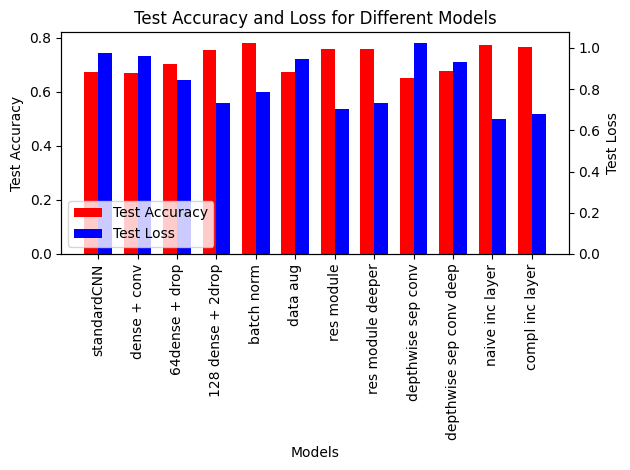

In [ ]:
test_losses = [test_1_loss, test_2_loss, test_3_loss, test_4_loss, test_5_loss, test_6_loss, test_7_loss, test_8_loss, test_9_loss, test_10_loss, test_11_loss, test_12_loss]
test_accuracies = [test_1_acc, test_2_acc, test_3_acc, test_4_acc, test_5_acc, test_6_acc, test_7_acc, test_8_acc, test_9_acc, test_10_acc, test_11_acc, test_12_acc]

plt.figure(figsize=(10, 8))
width = 0.35
x = np.arange(len(models_name))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

bar1 = ax1.bar(x - width/2, test_accuracies, width, color='red', label='Test Accuracy')
bar2 = ax2.bar(x + width/2, test_losses, width, color='blue', label='Test Loss')

ax1.set_xlabel("Models")
ax1.set_ylabel("Test Accuracy")
ax2.set_ylabel("Test Loss")

ax1.set_xticks(x)
ax1.set_xticklabels(models_name, rotation=90)
ax1.set_title("Test Accuracy and Loss for Different Models")

labels = ['Test Accuracy', 'Test Loss']
handles = [bar1, bar2]
plt.legend(handles, labels, loc='lower left')

plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate

data = {
    'Model': models_name,
    'Test Accuracy': test_accuracies,
    'Test Loss': test_losses
}

table = tabulate(data, headers='keys', tablefmt='fancy_grid')

print(table)

╒═════════════════════════╤═════════════════╤═════════════╕
│ Model                   │   Test Accuracy │   Test Loss │
╞═════════════════════════╪═════════════════╪═════════════╡
│ standardCNN             │        0.67354  │    0.976656 │
├─────────────────────────┼─────────────────┼─────────────┤
│ dense + conv            │        0.670103 │    0.960344 │
├─────────────────────────┼─────────────────┼─────────────┤
│ 64dense + drop          │        0.704467 │    0.843081 │
├─────────────────────────┼─────────────────┼─────────────┤
│ 128 dense + 2drop       │        0.754296 │    0.733071 │
├─────────────────────────┼─────────────────┼─────────────┤
│ batch norm              │        0.780928 │    0.785476 │
├─────────────────────────┼─────────────────┼─────────────┤
│ data aug                │        0.672251 │    0.945734 │
├─────────────────────────┼─────────────────┼─────────────┤
│ res module              │        0.757302 │    0.701343 │
├─────────────────────────┼─────────────